In [29]:
%matplotlib inline

import os
import datacube
import pickle
import numpy as np
import pandas as pd
import xarray as xr
import datetime as dt
import matplotlib.pyplot as plt

import sys
sys.path.insert(1, '../Tools/')
from dea_tools.datahandling import load_ard
from dea_tools.plotting import display_map, rgb
from dea_tools.dask import create_local_dask_cluster

import warnings

In [30]:
start = dt.datetime.now()
print(start)

2024-04-16 01:24:19.652056


In [31]:
warnings.simplefilter(action='ignore', category=FutureWarning)

# Create local dask cluster to improve data load time
client = create_local_dask_cluster(return_client=True)

/env/lib/python3.10/site-packages/distributed/node.py:183: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 42745 instead
  warnings.warn(


<Client: 'tcp://127.0.0.1:44115' processes=1 threads=2, memory=12.21 GiB>

In [32]:
dc = datacube.Datacube(app='download')

In [33]:
# Define area of interest
bbox = [149.04233704074215, -35.31567618156864, 149.11305927093008, -35.25740878873532]
lat_range = (bbox[1], bbox[3])
lon_range = (bbox[0], bbox[2])

# Set the range of dates for the analysis
time_range = ('2019-01-01', '2025-01-01')

# outpath = 'sentinel_arbo_3bands_2019-2024.pickle'
# bands = ['nbart_red', 'nbart_green', 'nbart_blue']

outpath = 'sentinel_arbo_4bands_2019-2024.pickle'
bands = ['nbart_red', 'nbart_green', 'nbart_blue', 'nbart_nir_1']


In [34]:
display_map(x=lon_range, y=lat_range)

In [35]:
# Create a reusable query
query = {
    'y': lat_range,
    'x': lon_range,
    'time': time_range,
    # 'measurements': ['nbart_red', 'nbart_green', 'nbart_blue'],
    'measurements': bands,
    'resolution': (-10, 10),
    'output_crs': 'epsg:32755',
    'group_by':'solar_day'
}

# Load available data from Sentinel-2
ds = load_ard(
    dc=dc,
    products=['ga_s2am_ard_3', 'ga_s2bm_ard_3'],
    cloud_mask='s2cloudless',
    min_gooddata=0.9,
    **query,
)

# Shut down Dask client now that we have loaded the data we need
client.close()

# Preview data
ds

Finding datasets
    ga_s2am_ard_3
    ga_s2bm_ard_3
Counting good quality pixels for each time step using s2cloudless


/env/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


Filtering to 144 out of 376 time steps with at least 90.0% good quality pixels
Applying s2cloudless pixel quality/cloud mask
Loading 144 time steps


<xarray.Dataset>
Dimensions:      (time: 144, y: 660, x: 657)
Coordinates:
  * time         (time) datetime64[ns] 2019-01-15T00:06:27.817000 ... 2024-04...
  * y            (y) float64 6.096e+06 6.096e+06 6.096e+06 ... 6.09e+06 6.09e+06
  * x            (x) float64 6.857e+05 6.857e+05 ... 6.922e+05 6.922e+05
    spatial_ref  int32 32755
Data variables:
    nbart_red    (time, y, x) float32 706.0 630.0 770.0 ... 1.29e+03 2.064e+03
    nbart_green  (time, y, x) float32 635.0 560.0 681.0 ... 1.115e+03 1.764e+03
    nbart_blue   (time, y, x) float32 416.0 380.0 453.0 ... 825.0 1.435e+03
    nbart_nir_1  (time, y, x) float32 2.197e+03 2.274e+03 ... 2.533e+03
Attributes:
    crs:           epsg:32755
    grid_mapping:  spatial_ref

**Once the load is complete**, we can plot some of the images as as a true-colour image using the `rgb` function.  

/env/lib/python3.10/site-packages/matplotlib/cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


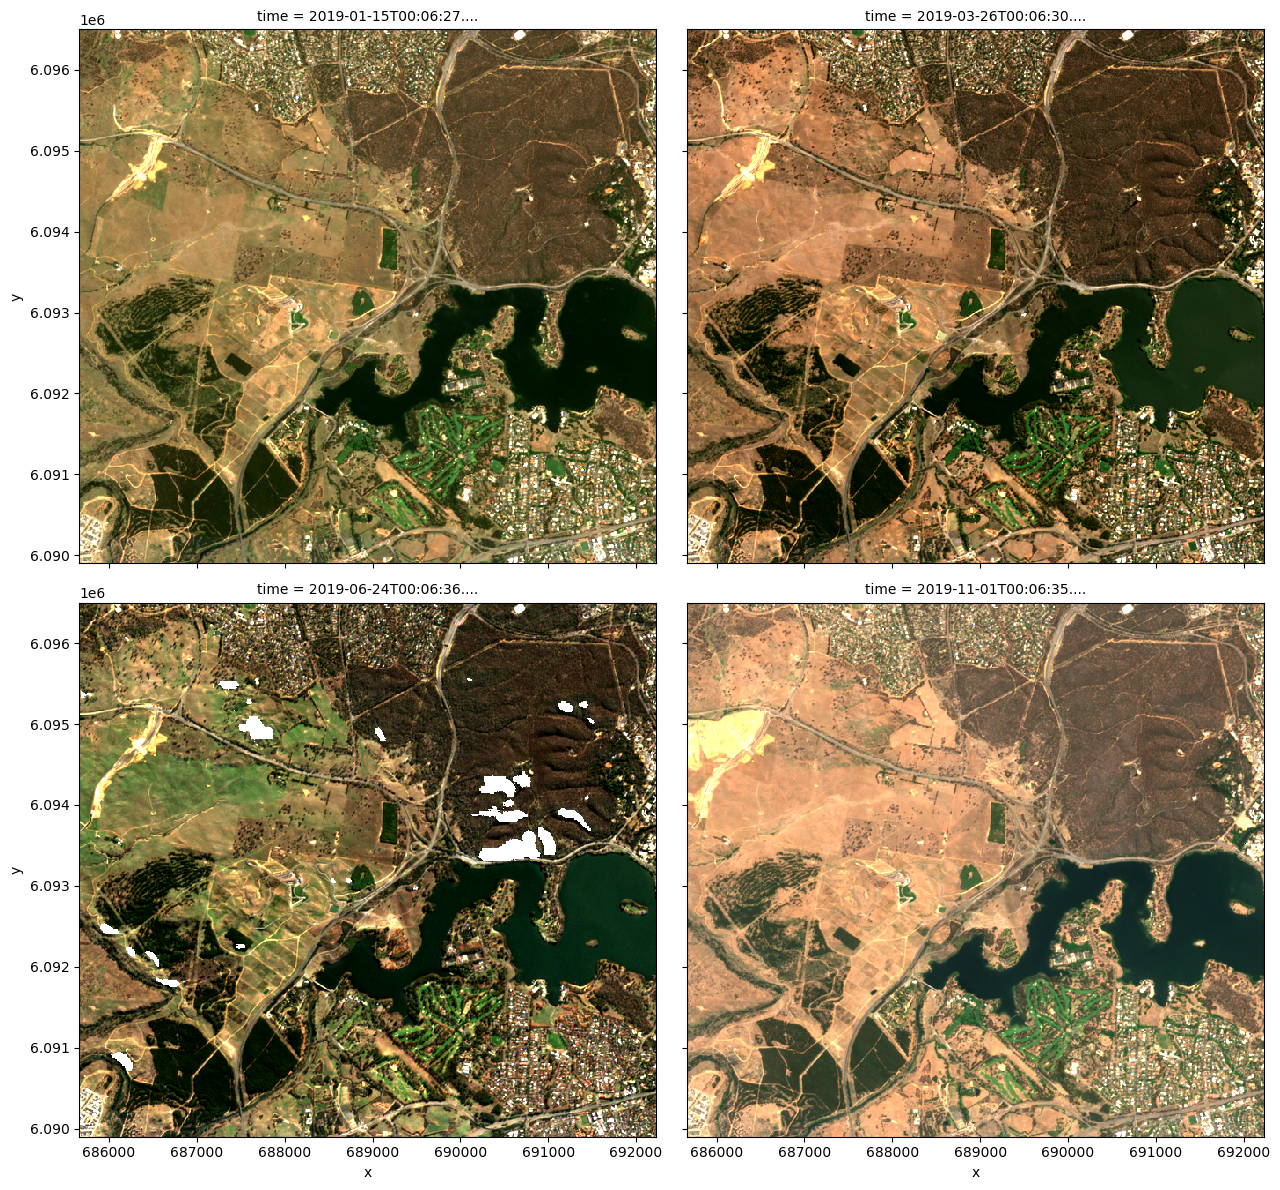

In [36]:
rgb(ds, index=[0, 10, 20, 30], col_wrap=2)

In [37]:
with open(outpath, 'wb') as handle:
    pickle.dump(ds, handle, protocol=pickle.HIGHEST_PROTOCOL)
outpath

'sentinel_arbo_4bands_2019-2024.pickle'

In [38]:
end = dt.datetime.now()
print(end-start)

0:04:49.775424
